In [1]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy
import numpy as np
import joblib
from pandarallel import pandarallel
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re
import math
import os
from sklearn.metrics import make_scorer, average_precision_score
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.cluster import KMeans


2024-04-12 10:11:53.578017: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 10:11:53.626168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 10:11:53.834860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 10:11:53.834890: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 10:11:53.837277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
def optimize_hyperparameters(X, y):
    # Initialize a BalancedRandomForestClassifier
    clf = BalancedRandomForestClassifier(replacement=True)

    # Define hyperparameters grid
    param_grid = {
        'n_estimators': [500,800,1200],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'sampling_strategy': ['majority','not majority','all']
    }

    # Set up k-fold cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    alpha = 0.1
    geo_mean = make_index_balanced_accuracy(alpha=alpha, squared=True)(geometric_mean_score)
    gmean = make_scorer(geo_mean, average='weighted')
    # Función que inverte el primer y segundo argumento para adaptarse al formato de `make_scorer`
        
    # Grid search with cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=kfold, scoring=gmean, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)
    return grid_search

def preprocess_features(data,columns,bad_values):
    """
    Realiza el preprocesamiento de las características especificadas.

    Args:
    - data (pd.DataFrame): DataFrame original con los datos.

    Returns:
    - data (pd.DataFrame): DataFrame procesado con características adicionales y filas inválidas eliminadas.
    """
    
    # Busca valores 999 o -999 en las columnas especificadas
    invalid_values = data[columns].isin([bad_values, -bad_values]).sum()

    # Filtra y muestra solo las columnas que tienen estos valores inválidos
    columns_with_invalids = invalid_values[invalid_values > 0]

    if columns_with_invalids.empty:
        print(f" Todas las columnas tienen datos válidos, sin valores {bad_values} o -{bad_values}.")
    else:
        print(f"Las siguientes columnas tienen valores {bad_values} o -{bad_values}:\n{columns_with_invalids}")

    # Filtra el DataFrame para excluir filas con valores 999 o -999 en las columnas especificadas
    data = data[~data[columns].isin([bad_values, -bad_values]).any(axis=1)].reset_index(drop=True)

    return data

In [3]:


ray.init()

@ray.remote
def parallel_function(train_index, test_index, iteration, X, y, best_params):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    best_params['replacement'] = True
    best_brfc = BalancedRandomForestClassifier(**best_params)
    best_brfc.fit(X_train, y_train)
    y_pred = best_brfc.predict(X_test)

    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    array_2,_ = C_M(y_test, y_pred)
    
    results = []
    classes = list(set(y_test))
    for cls, precision, recall, f1 in zip(classes, precision_per_class, recall_per_class, f1_per_class):
        results.append({
            'Iteration': iteration,
            'Class': cls,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    return array_2, results

def C_M(label,predict_label):
    array = np.array(tf.math.confusion_matrix(label,predict_label) )
    df = pd.DataFrame(array)
    perc = df.copy()
    cols = perc.columns.values
    perc[cols] = perc[cols].div(perc[cols].sum(axis=1), axis=0).multiply(100)
    annot = df.round(2).astype(str) + "\n" + perc.round(1).astype(str) + "%"
    return array, annot


2024-04-12 10:11:58,009	INFO worker.py:1673 -- Started a local Ray instance.


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

class DataFrameScaler:
    def __init__(self):
        self.scalers = {}

    def scale(self, df):
        """
        Escala las columnas del DataFrame a media 0 y desviación estándar 1.
        """
        scaled_df = df.copy()
        for column in df.columns:
            scaler = StandardScaler()
            scaled_df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1)).flatten()
            self.scalers[column] = scaler
        return scaled_df

    def inverse_scale(self, df):
        """
        Devuelve el DataFrame escalado a su estado original.
        """
        original_df = df.copy()
        for column in df.columns:
            scaler = self.scalers.get(column)
            if scaler:
                original_df[column] = scaler.inverse_transform(df[column].values.reshape(-1, 1)).flatten()
        return original_df

from itertools import combinations

def create_color_columns(mag_features, df):
    """
    Crea columnas de colores en el DataFrame df basadas en las combinaciones de mag_features.
    
    Parámetros:
    - mag_features: Lista de características para hacer combinaciones y crear colores.
    - df: DataFrame donde se añadirán las nuevas columnas de colores.
    
    Retorna:
    - df: DataFrame modificado con las nuevas columnas de colores.
    - colors: Lista de los nombres de las nuevas columnas de colores.
    """
    colors = []
    for v in combinations(mag_features, 2):
        df[f"{v[0]}-{v[1]}"] = df[v[0]] - df[v[1]]
        colors.append(f"{v[0]}-{v[1]}")
    return df, colors

In [5]:
def plot_confusion_matrix(CM_array, CM_std,labels,path='/home/marcelo/nico/MasivasData/Confusion_matrix_skiff_rf.pdf'):
    """
    Función para graficar una matriz de confusión con errores estándar.
    
    Parámetros:
    - CM_array: Matriz de confusión.
    - CM_std: Matriz de errores estándar.
    """
    # Calculate the scaling factor
    factor = math.sqrt(10**2 + 8**2) / math.sqrt(6**2 + 4**2)

    # Convertir la matriz de confusión a porcentaje
    CM_percentage = CM_array / CM_array.sum(axis=1)[:, None] * 100
    CM_std_percentage = CM_std / CM_array.sum(axis=1)[:, None] * 100

    # Crear el plot
    plt.figure(figsize=(7, 7))

    # Adjust the font size based on the scaling factor
    base_fontsize = 14
    adjusted_fontsize = int(base_fontsize * factor)

    # Crear un array con las anotaciones que incluyen el error
    annotations = np.array([
        [f"{CM_percentage[i, j]:.2f} ± {CM_std_percentage[i, j]:.2f}%" for j in range(CM_percentage.shape[1])]
        for i in range(CM_percentage.shape[0])
    ])

    # Crear el heatmap
    sns.heatmap(CM_percentage, annot=annotations, fmt="", cmap="YlGnBu", cbar=False,
                annot_kws={"size": 14}, linewidths=0.5, linecolor="gray",
                xticklabels=labels, yticklabels=labels)

    # Configuración de las etiquetas
    plt.ylabel('True Label', fontsize=adjusted_fontsize)
    plt.xlabel('Predicted Label', fontsize=adjusted_fontsize)
    plt.xticks(rotation=45, fontsize=adjusted_fontsize)  # Rotación de las etiquetas del eje X y ajuste del fontsize
    plt.yticks(fontsize=adjusted_fontsize)

    plt.savefig(path, format='pdf', bbox_inches='tight')
    plt.show()

In [6]:

def plot_barplot(df, probability_col, label_col, bins, plot_type='mean_std'):
    plt.figure(figsize=(15, 6))

    # Utiliza pd.cut para categorizar los datos en los bins definidos
    df['Categoria'] = pd.cut(df[label_col], bins=bins, include_lowest=True, right=False)

    if plot_type == 'mean_std':
        # Calcula el promedio y la desviación estándar de la columna de probabilidad para cada categoría
        estadisticas = df.groupby('Categoria')[probability_col].agg(['mean', 'std'])

        # Crea el bar plot con el promedio y la desviación estándar
        plt.bar(estadisticas.index.astype(str), estadisticas['mean'], 
                yerr=estadisticas['std'], capsize=5, edgecolor='black')
        plt.ylabel('Promedio de Probabilidades (%)')

    elif plot_type == 'count':
        # Calcula la cuenta de cada categoría
        counts = df['Categoria'].value_counts().sort_index()

        # Convierte las cuentas a porcentaje del total
        counts_percentage = (counts / counts.sum()) * 100

        # Crea el bar plot con la cuenta de los bines en porcentaje
        plt.bar(counts_percentage.index.astype(str), counts_percentage, edgecolor='black')
        plt.ylabel('Porcentaje del Total (%)')

    plt.xlabel('Intervalos')
    plt.title(f'Bar Plot de {probability_col}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return df


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(df,path_name):
    # Crear subconjuntos de datos
    df_test = df.loc[df['B2_cut_split'] == 'test']
    df_test_sin_B = df_test.loc[(df_test['numeric_sp'] < 1) | (df_test['numeric_sp'] >= 2)]
    df_sin_Early_B = df_test.loc[(df_test['numeric_sp'] < 1) | (df_test['numeric_sp'] > 1.2)]

    # Calcular Precision-Recall para el DataFrame completo
    precision, recall, thresholds = precision_recall_curve(df_test['B2'], df_test['B2_cut_probability'])
    thresholds = np.append(thresholds, 1)

    # Calcular Precision-Recall para el DataFrame sin Early B
    p_sub, r_sub, t_sub = precision_recall_curve(df_sin_Early_B['B2'], df_sin_Early_B['B2_cut_probability'])
    t_sub = np.append(t_sub, 1)

    # Crear el gráfico
    plt.figure(figsize=(8, 8))

    # Graficar precisión y recall para el DataFrame completo
    plt.plot(thresholds, precision, color='red', lw=1.5, label='Precision All Sample')
    plt.plot(thresholds, recall, color='black', lw=1.5, label='Recall All Sample')

    # Graficar precisión y recall para el DataFrame sin Early B
    plt.plot(t_sub, p_sub, color='red', linestyle='dotted', lw=1.5, label='Precision No Early B')
    plt.plot(t_sub, r_sub, color='black', linestyle='dotted', lw=1.5, label='Recall No Early B')

    # Configuración de etiquetas y título
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.title('Precision-Recall vs Threshold')

    # Añadir leyenda y rejilla
    plt.legend(loc='lower left')
    plt.grid(True)

    # Añadir más ticks en los ejes
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 11))

    plt.savefig(path_name, format='pdf', bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()




In [7]:
def plot_contour(dataframe, column_x, column_y,bins,last_contour=False, ax=None):
    # Crear la figura y el eje si no se proporciona uno
    if ax is None:
        fig, ax = plt.subplots()

    # Extraer los datos de las columnas especificadas
    x = dataframe[column_x]
    y = dataframe[column_y]

    # Crear un histograma bidimensional
    x_bins = np.linspace(x.min(), x.max(),bins)  # Ajusta el número de bins según sea necesario
    y_bins = np.linspace(y.min(), y.max(), bins)  # Ajusta el número de bins según sea necesario
    H, x_edges, y_edges = np.histogram2d(x, y, bins=(x_bins, y_bins))

    # Convertir el histograma a densidades
    H = H.T  # Transponer para corregir el orden de los ejes
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

    # Dibujar los contornos
    contour = ax.contour(X, Y, H, levels=10, colors='black')  # Ajusta el número de niveles según sea necesario
    # Mostrar el gráfico si se creó un nuevo eje
    if ax is None:
        plt.show()
    if last_contour is True:
        return contour

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_discretized_probability(df,path_name):
    # Discretizar la probabilidad 
    df["bins"] = pd.cut(df["B2_cut_probability"], bins=np.linspace(0, 1, 11), include_lowest=True)
    discret_prob = df["bins"].unique().sort_values()
    df = df.loc[df["B2_cut_split"] != "train"]

    # Crear la figura y los ejes
    fig, axs = plt.subplots(1, len(discret_prob) + 1, figsize=(50, 10), sharex=True, sharey=True)

    tick_size = 24  # Ajusta este valor según tus necesidades
    legend_size = 24  # Ajusta este valor según tus necesidades

    # Iterar sobre cada eje para dibujar el histograma
    for i, ax in enumerate(axs.flatten()):
        if i == 0:
            last_contour = plot_contour(dataframe=df, column_x="j_ks_0", column_y="bp_rp", bins=150, last_contour=True, ax=ax)
            ax.set_title("Probability: All", fontsize=24)
        else:
            plot_contour(dataframe=df.loc[df["bins"] == discret_prob[i-1]], column_x="j_ks_0", column_y="bp_rp", bins=30, ax=ax)
            ax.contour(last_contour, levels=[0], colors='red')
            ax.set_title(f"Probability: {discret_prob[i-1]}", fontsize=24)
        ax.tick_params(axis='both', labelsize=tick_size)

    # Ajustes finales y guardado
    plt.tight_layout()
    fig.text(0.5, -0.04, r"$(J-K_{s})_{0}$", ha='center', va='center', fontsize=30)
    fig.text(-0.01, 0.5, r"$BP-RP$", ha='center', va='center', rotation='vertical', fontsize=30)
    plt.savefig(path_name, bbox_inches='tight')
    return df

# Uso de la función
# plot_discretized_probability(tu_dataframe)


In [9]:
def perform_grid_search_and_validation(X, y, path, base_filename,df,df_total):
    # Crear la carpeta con el nombre base_filename si no existe
    full_path = os.path.join(path, base_filename)
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # Iniciar la búsqueda de hiperparámetros
    grid_search = optimize_hyperparameters(X, y)
    best_params, best_score = grid_search.best_params_, grid_search.best_score_
    feature_importances = grid_search.best_estimator_.feature_importances_
    features = X.columns
    sorted_features = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

    pd.DataFrame([best_params]).to_csv(f'{full_path}/_best_params.csv', index=False)
    pd.DataFrame(sorted_features, columns=['Feature', 'Importance']).to_csv(f'{full_path}/_features_importance.csv', index=False)

    # Iniciar la validación cruzada
    array = np.zeros((len(np.unique(y)), len(np.unique(y)), 20))
    results = []
    sss = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

    futures = [parallel_function.remote(train_index, test_index, iteration, X, y, best_params) for iteration, (train_index, test_index) in enumerate(sss.split(X, y))]

    iteration = 0
    for future in ray.get(futures):
        array_2, result = future
        array[:, :, iteration] = array_2
        results.extend(result)
        iteration += 1
    ray.shutdown()

    results = pd.DataFrame(results)
    CM_array = array.mean(axis=2)
    CM_std = array.std(axis=2)
    plot_confusion_matrix(CM_array, CM_std,["Later B2", "Early B2"],f'{full_path}/Confusion_matrix.pdf')
    
    #entrenamiento de un modelo
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_params['replacement'] = True
    best_brfc = BalancedRandomForestClassifier(**best_params)
    best_brfc.fit(X_train, Y_train)
    joblib.dump(best_brfc,f'{full_path}/skiff_rf.sav')
    # predecir todo el modelo 
    df_total.loc[X_train.index,'B2_cut_split'] = 'train'
    df_total.loc[X_test.index,'B2_cut_split'] = 'test'
    df_total.loc[df_total["B2_cut_split"].isna(),"B2_cut_split"] = "no_used"
    df_total['B2_cut_probability'] = best_brfc.predict_proba(df_total[best_brfc.feature_names_in_])[:, 1]
    df_total[best_brfc.feature_names_in_] = scaler.inverse_scale(df_total[best_brfc.feature_names_in_])
    df_total.to_csv(f'{full_path}/Data.csv',index=False)    
    #Plot presicion-Recall
    plot_precision_recall(df_total,f'{full_path}/Precision_Recall.pdf')
    
    #Plot discretizacion de normalizacion
    plot_discretized_probability(df_total,f'{full_path}/discretizacion_prob.pdf')
    
    return best_params, best_score, sorted_features, results, CM_array, CM_std


In [10]:
def create_histogram(data1,data2, column, ax, data_labels=['Zari', 'Skiff'],
                     colors=['black', 'red'],cuts=True):
    # Asegúrate de que 'data_labels' tenga al menos 2 etiquetas
    if len(data_labels) < 2:
        raise ValueError("data_labels debe tener al menos dos etiquetas.")

    # Separar los datos en dos conjuntos
    data1 = data1[column]
    data2 = data2[column]

    # Calcular los bins
    bins = np.linspace(data1.min(),data1.max(), 50)

    # Dibujar los histogramas
    ax.hist(data1, bins=bins, alpha=0.5, color=colors[0], edgecolor='black', label=data_labels[0])
    ax.hist(data2, bins=bins, alpha=0.5, color=colors[1], edgecolor='black', label=data_labels[1])

    # Establecer la escala logarítmica en el eje y
    ax.set_yscale('log')
    
    lower_x = data1.quantile(0.000001)
    upper_x = data1.quantile(0.999999)
    ax.set_xlim(lower_x, upper_x)
    ax.set_xlabel(column)
    # Agregar líneas verticales para los límites
    if cuts ==True:
        lower_bound = data2.quantile(0.01)
        upper_bound = data2.quantile(0.99)
        ax.axvline(lower_bound, color='orange', linestyle='dashed', linewidth=2, label='Lower limit 1%')
        ax.axvline(upper_bound, color='purple', linestyle='dashed', linewidth=2, label='Upper limit 99%')
            # Añadir títulos y etiquetas
        return (lower_bound,upper_bound)
    else:
        return


In [12]:
pandarallel.initialize(nb_workers=29,progress_bar=True)

INFO: Pandarallel will run on 29 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [17]:
df = pd.read_csv("/home/nicolas/nico/Data/Masivas/23_01_2024/ZariDR3_Prep_2arcscSkiff.csv")

In [18]:
#df_2 = pd.read_csv("/home/nicolas/nico/Data/Masivas/23_01_2024/Gaia_Brither_than_16G_internalmatch5arcsec.csv")
#df = df.merge(df_2[['source_id','tmass_oid','GroupID', 'GroupSize']],how="left",on=["source_id","tmass_oid"])
#df.loc[df["GroupID"].isna(),"GroupID"] = 0
#df.loc[df["GroupSize"].isna(),"GroupSize"] = 1

In [19]:
path_plots = "/home/nicolas/nico/Data/Masivas/23_01_2024/plots/"

In [20]:
path = "/home/nicolas/nico/Data/Masivas/23_01_2024/results/"


In [21]:
mag_features = ['j_m', 'h_m', 'ks_m','phot_g_mean_mag',
                           'phot_bp_mean_mag', 'phot_rp_mean_mag']
astrometric = [
    "parallax_error",
    "parallax_over_error",
    "parallax",
    "pmra",
    "pmdec",
    "pmdec_error",
    "pmra_error",
    "astrometric_sigma5d_max",
    "astrometric_excess_noise",
    "ruwe",
    "astrometric_gof_al",
    "ipd_gof_harmonic_amplitude",
    "astrometric_excess_noise_sig"]

# Cambiamos el nombre de las variables por estetica


New_names_mag_features = ['Jmag', 'Hmag', 'Ksmag','Gmag',
                           'BPmag', 'RPmag']
New_names_astrometric =  [
    "Parallax_error",
    "Parallax_over_error",
    "Parallax",
    "pmRA",
    "pmDEC",
    "pmDEC_error",
    "pmRA_error",
    "Sigma5d_max",
    "Excess_noise",
    "RUWE",
    "Gof_al",
    "Ipd_gof_harmonic_amplitude",
    "Excess_noise_sig"]




In [22]:
rename_dict = dict(zip(mag_features+astrometric, New_names_mag_features+New_names_astrometric))

# Renombrar las columnas en el DataFrame
df = df.rename(columns=rename_dict)

In [23]:
mag_features = New_names_mag_features
astrometric = New_names_astrometric

In [24]:
features_name = mag_features+astrometric

In [25]:
df = preprocess_features(df,features_name,np.nan)
df, colors = create_color_columns(mag_features, df)
df = df.sort_values(by="numeric_sp").drop_duplicates(subset="tmass_oid",keep="first")

Las siguientes columnas tienen valores nan o -nan:
BPmag    11913
RPmag    11874
dtype: int64


In [26]:
features_name = mag_features+astrometric+colors

In [27]:
skiff = df.loc[df["numeric_sp"].notna()]

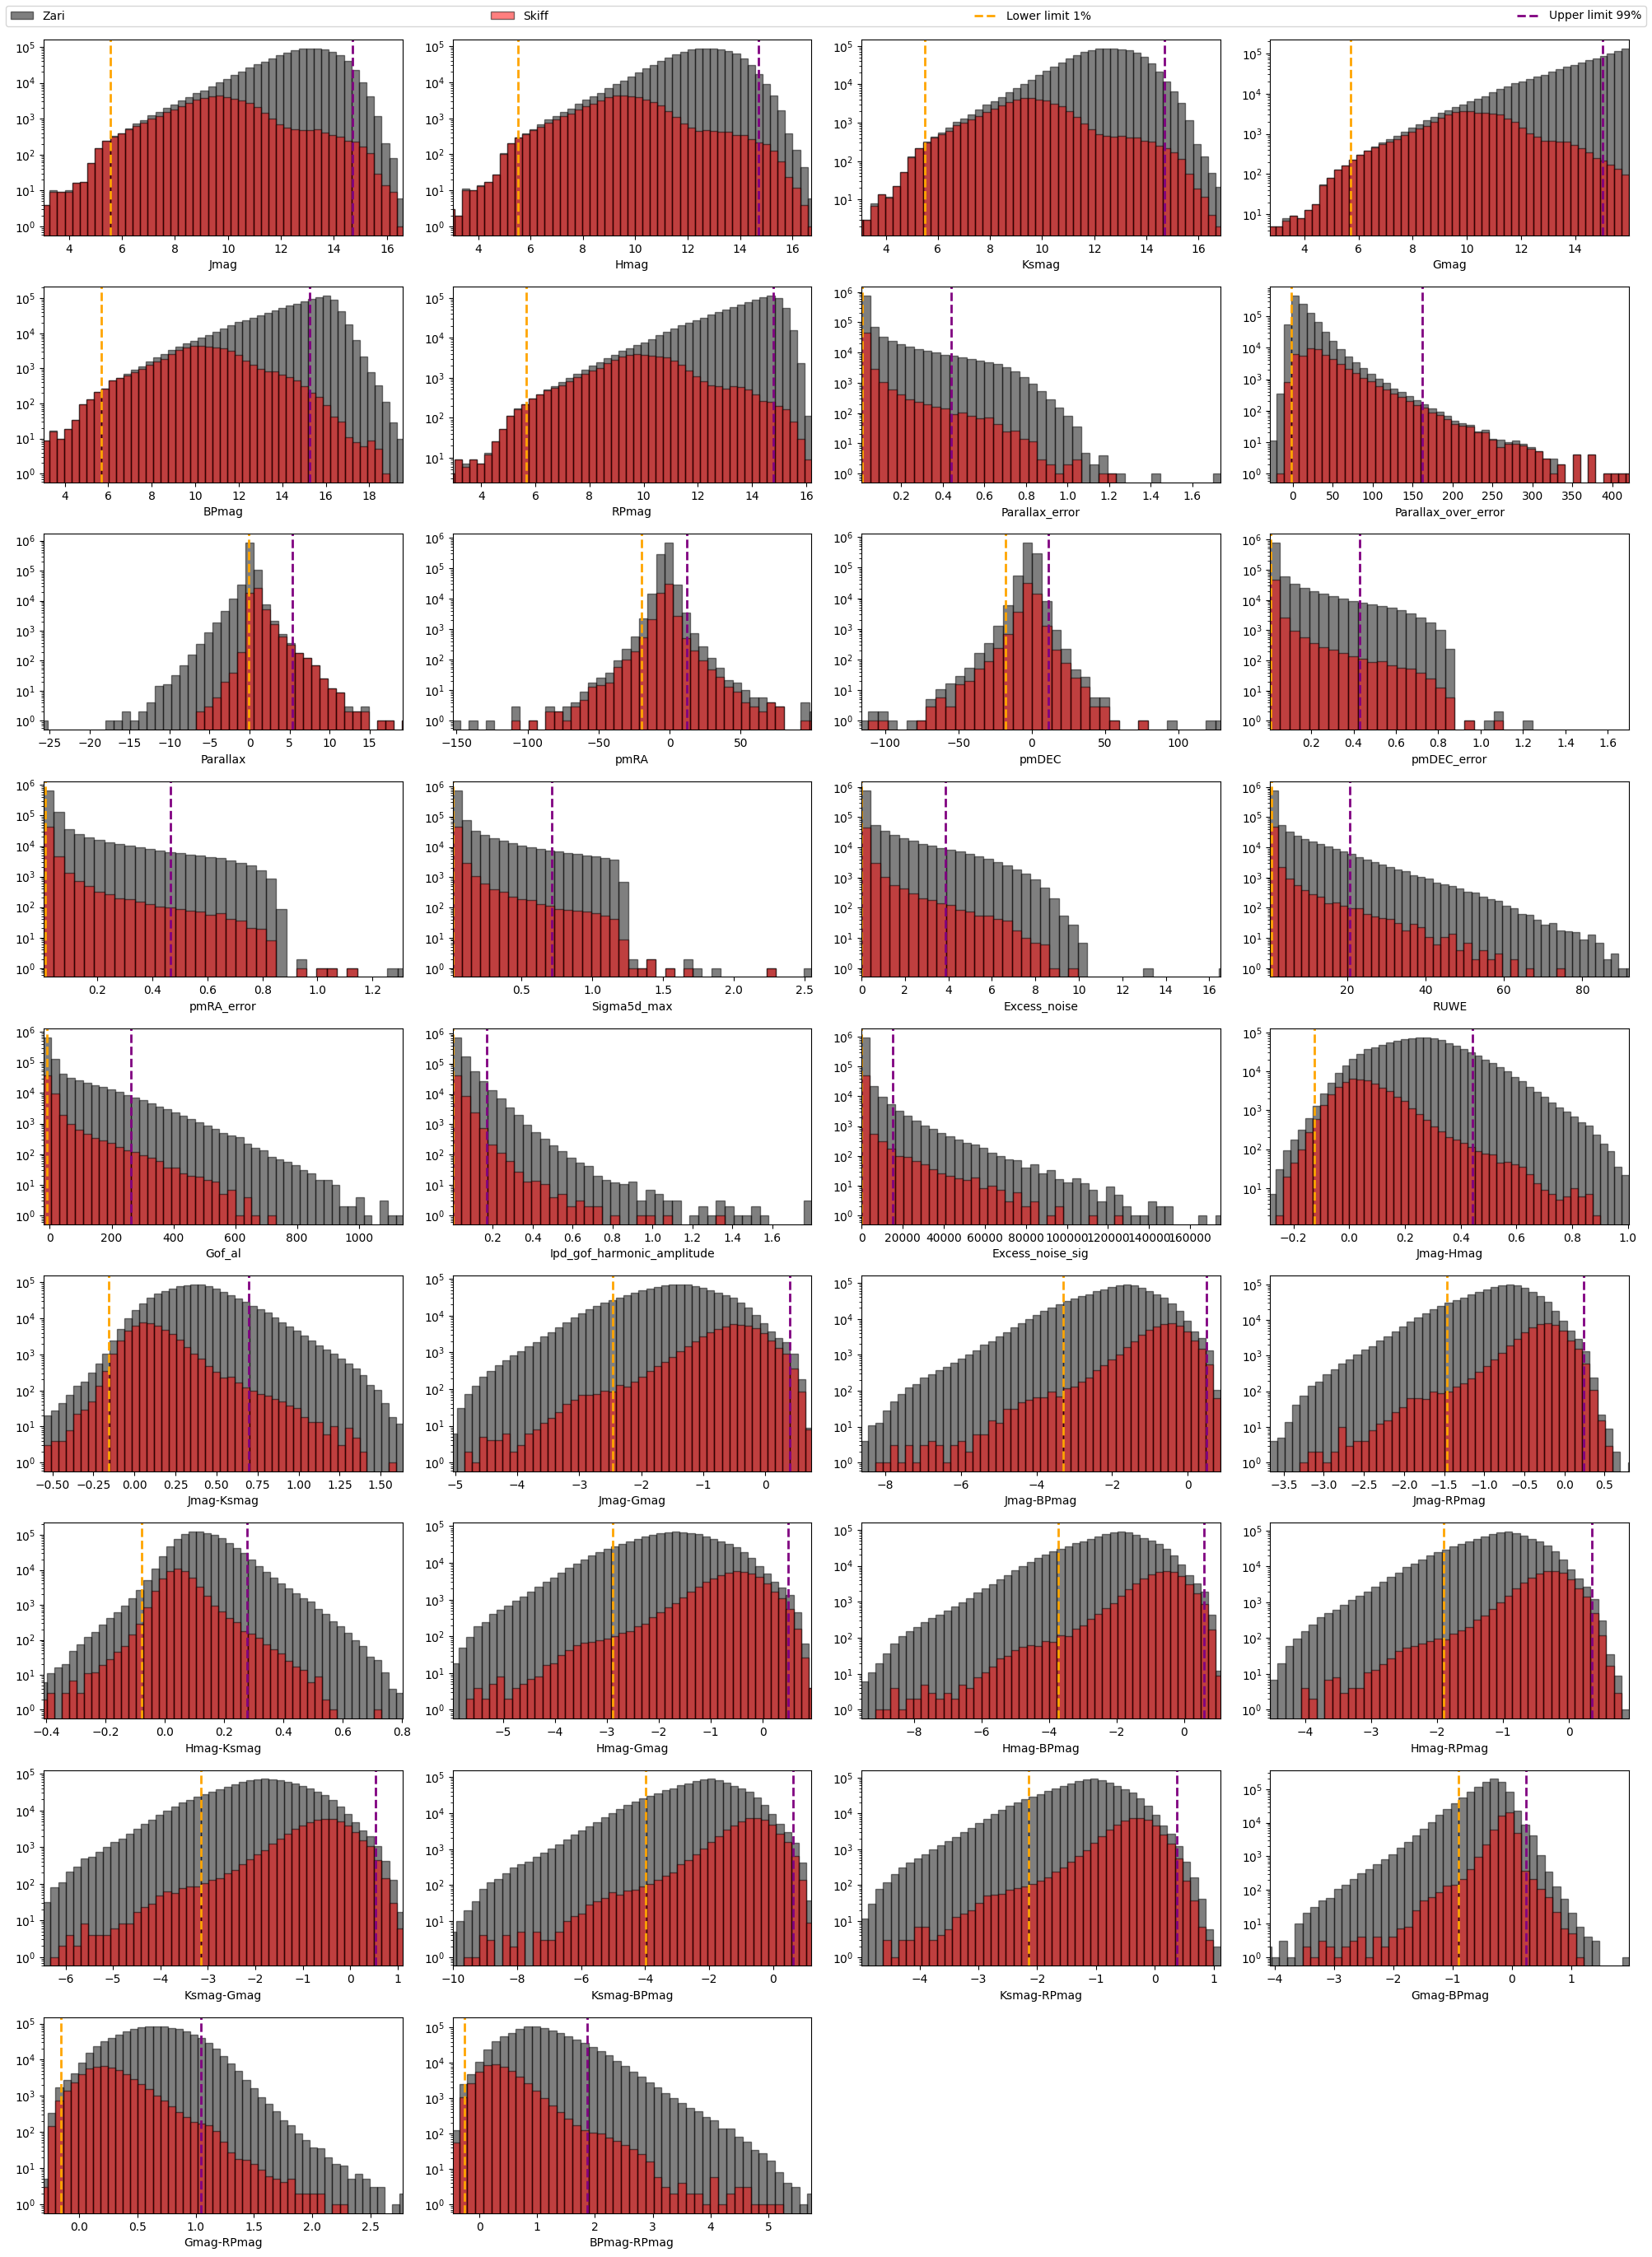

In [28]:
bound = []

# Crear una grilla de 2x2 para los subplots
fig, axs = plt.subplots(10, 4, figsize=(20, 30))

# Aplanar el arreglo de ejes para facilitar la iteración
flat_axs = axs.flatten()

# Iterar sobre cada eje para dibujar el histograma
for i, ax in enumerate(flat_axs):
    if i > len(features_name)-1:
        ax.remove()  # Eliminar el último eje si no es necesario
    else:
        bounds =create_histogram(df, skiff, features_name[i], ax)
        bound.append(bounds)
# Asumiendo que todos los subplots tienen la misma leyenda,
# se puede usar cualquier eje para obtener las manijas y etiquetas de la leyenda
handles, labels = flat_axs[0].get_legend_handles_labels()

# Crear leyenda global para la figura
fig.legend(handles, labels, loc='upper center', ncol=4, mode='expand')

# Ajustar el layout para evitar la superposición de elementos
plt.tight_layout()
plt.subplots_adjust(top=0.985)
#plt.savefig(f"{path_plots}Features_distribution.pdf", format='pdf', bbox_inches='tight')

# Mostrar el gráfico
plt.show()

In [29]:
for i,column in enumerate(features_name):
    df = df.loc[(df[column] >= bound[i][0])&(df[column] <= bound[i][1])]

In [30]:
skiff = df.loc[df["numeric_sp"].notna()]

In [31]:
from scipy import stats

In [32]:
stats_list = np.zeros(len(features_name))
p_values = []

In [34]:
def Kstest(df, skiff, features_name):
    return [stats.kstest(df[column].values, skiff[column].values).statistic for column in features_name]



In [35]:
df_kstest = pd.DataFrame({"Feature":features_name})
for mag in [10,11,12,13,14,15,16]:
    df_mag_costrain = df.loc[df["Gmag"]<=mag]
    skiff = df_mag_costrain[df_mag_costrain["numeric_sp"].notna()]
    result = Kstest(df_mag_costrain,skiff,features_name)
    col_name = f"Kstest_eqless{mag}"
    df_kstest[col_name] = result

In [36]:
colum_list = df_kstest.keys()[1:].to_list()

In [37]:
inverted_columns = list(df_kstest.keys()[1:])[::-1]

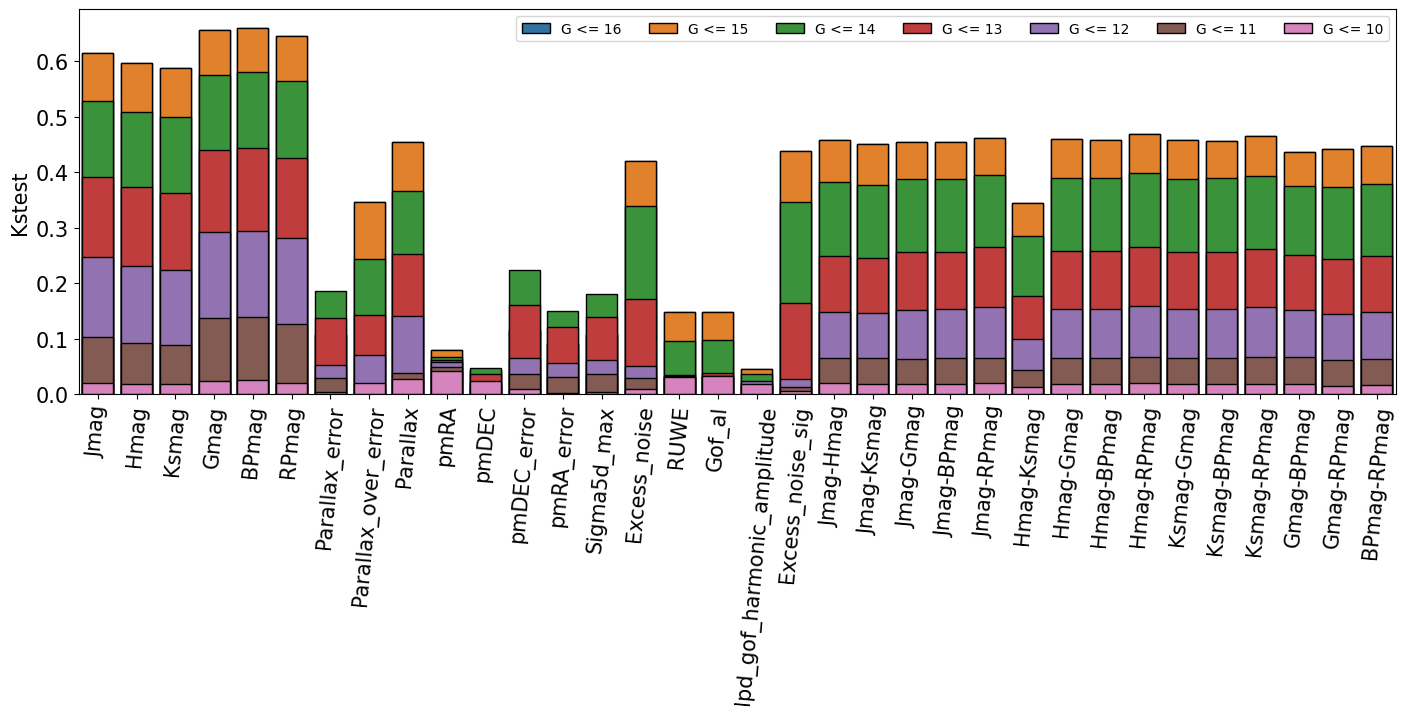

In [38]:
plt.figure(figsize=(17, 5))  # Increasing the size of the plot

# Definir una paleta de colores
#colors_plot = ["pink","brown","purple","red","green","orange","blue"]

for i, colum in enumerate(inverted_columns):
    # Usar el color correspondiente de la paleta para cada barra
    sns.barplot(data=df_kstest, x="Feature",edgecolor="black", y=colum, label="G <= "+ colum[-2:])

# Rotando las etiquetas del eje x para hacerlas casi verticales
plt.xticks(rotation=85)
plt.tick_params(axis='both', which='major', labelsize=15)  # Cambia '10' por el tamaño deseado
# Mostrar la leyenda
num_legend_items = len(df_kstest.keys()[1:])
plt.legend(ncol=num_legend_items)
plt.ylabel("Kstest",size=15)
plt.xlabel("",size=15)

#plt.savefig(f"{path_plots}Feature_with_Kstest.pdf", format='pdf', bbox_inches='tight')
# Mostrar el gráfico
plt.show()


In [39]:
df["bp_rp"] = df["Gmag"] - df["RPmag"]
df["j_ks_0"] = df["Jmag"] - df["Ksmag"] - 0.25*(df["Gmag"]-df["Ksmag"])
df.loc[df['numeric_sp']<=1.2,'B2'] = 1
df.loc[df['numeric_sp']>1.2,'B2'] = 0

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/nicolas/miniconda3/envs/RF/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
(pid=135010) 2024-01-31 20:48:29.648250: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=135010) 2024-01-31 20:48:29.649873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=135010) 2024-01-31 20:48:29.673006: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=135010) 2024-01-31 20:48:29.673035: E tensor

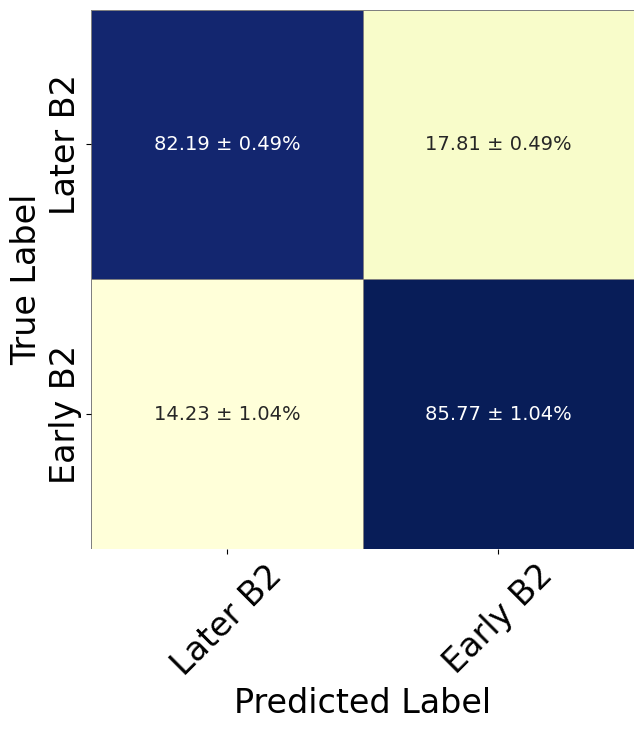

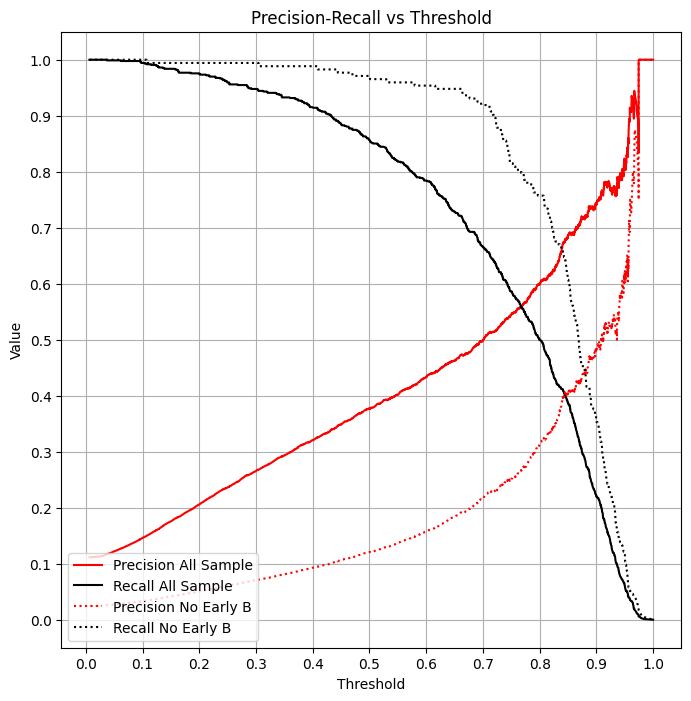

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/nicolas/miniconda3/envs/RF/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024-01-31 21:16:32,519	INFO worker.py:1673 -- Started a local Ray instance.
(pid=139366) 2024-01-31 21:16:33.552452: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=139366) 2024-01-31 21:16:33.554111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=139366) 2024-01-31 21:16:33.578398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one 

(pid=140722) 2024-01-31 21:16:55.012688: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`. [repeated 4x across cluster]
(pid=140722) 2024-01-31 21:16:55.053302: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used. [repeated 8x across cluster]
(pid=140722) 2024-01-31 21:16:55.047109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered [repeated 4x across cluster]
(pid=140722) 2024-01-31 21:16:55.047145: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered [repeate

(raylet) [2024-01-31 21:17:32,284 E 139253 139253] (raylet) node_manager.cc:3035: 21 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 662eb50151d808f250864b38657b71a21e375a3bb0734057e8613a79, IP: 172.16.41.97) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.16.41.97`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(parallel_function pid=140721) 2024-01-31 21:17:36.661613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dri

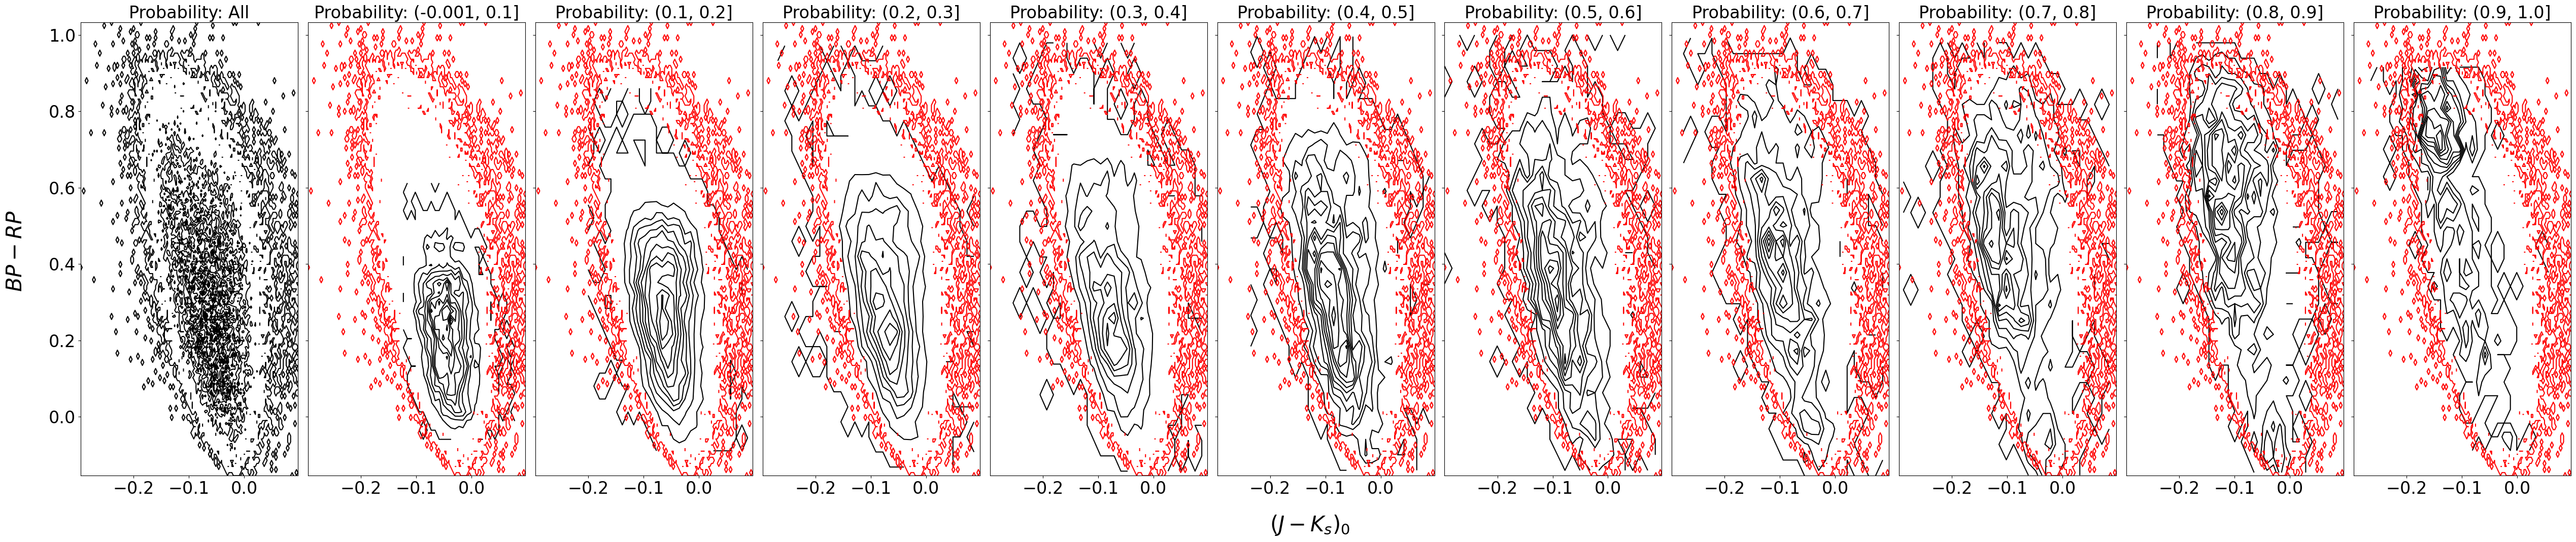

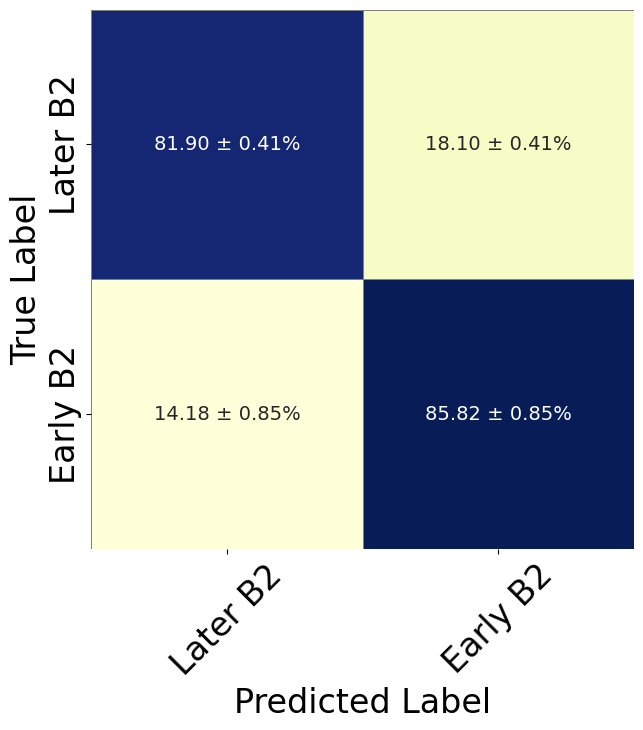

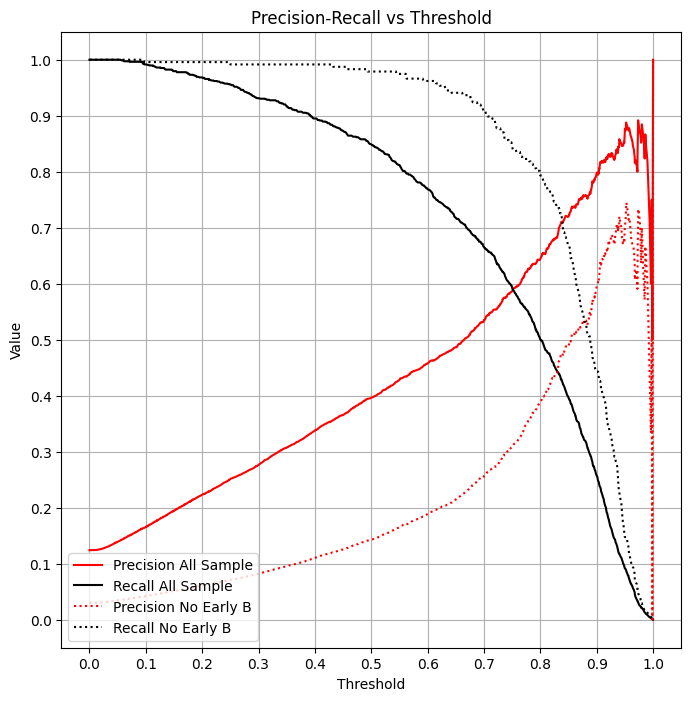

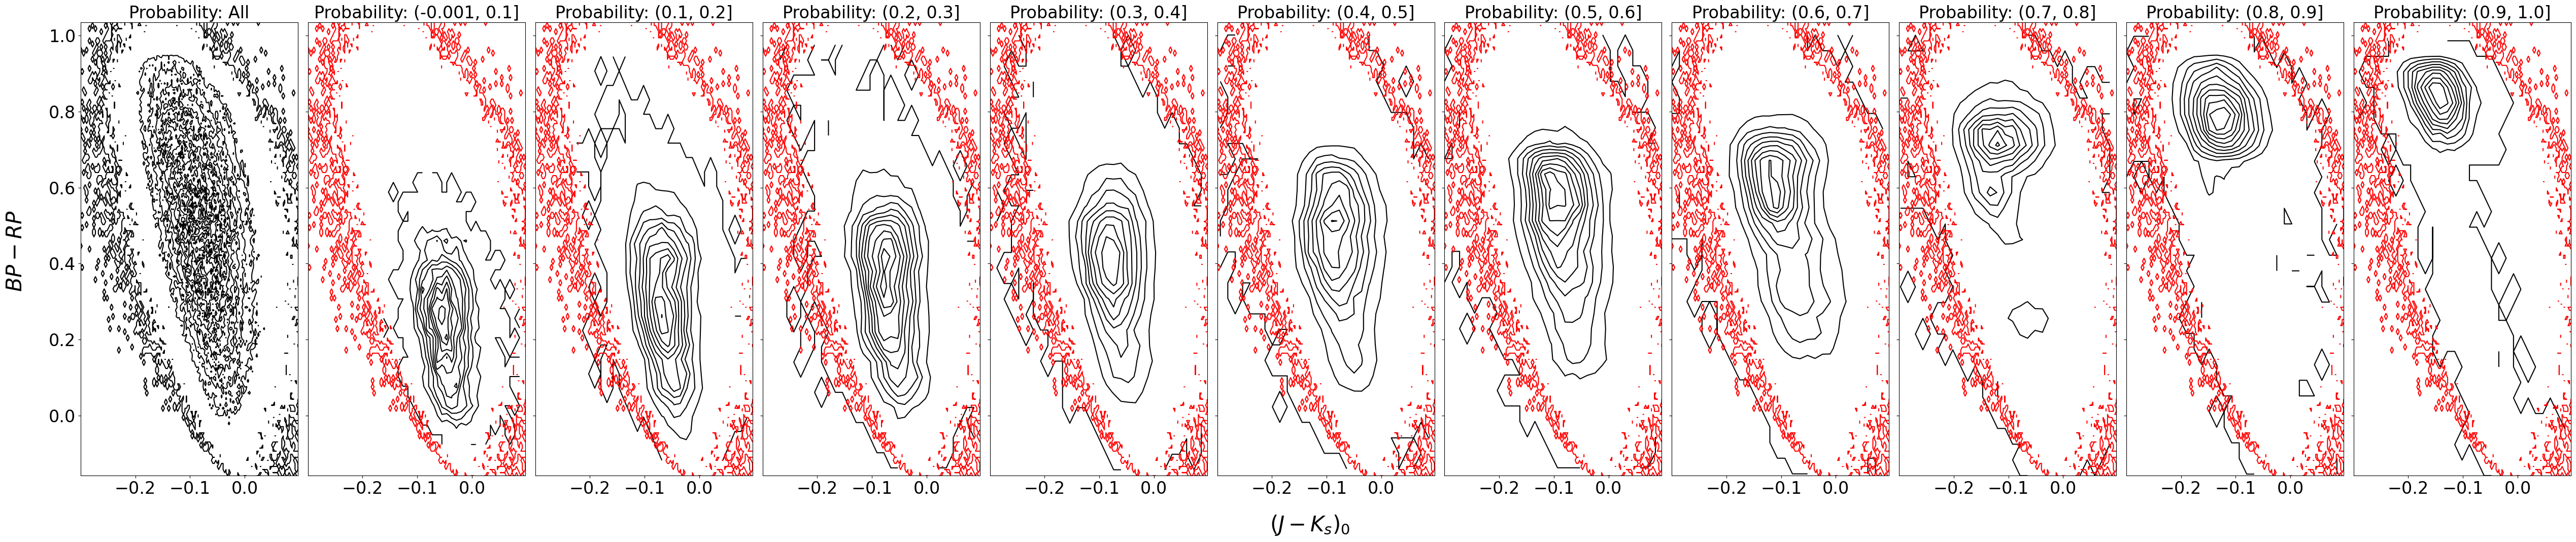

In [70]:
for Gmag in [12,16]:
    if Gmag >12:
        features_name_mag = astrometric+colors
    else :
        features_name_mag = features_name
    df_mag = df.loc[df["Gmag"]<=Gmag].reset_index(drop=True)
    scaler = DataFrameScaler()
    df_mag[features_name_mag] = scaler.scale(df_mag[features_name_mag])
    skiff_mag = df_mag.loc[df_mag["numeric_sp"].notna()].reset_index(drop=True)
    X = skiff_mag[features_name]
    y = skiff_mag['B2']
    base_filename = f"B2_cut_G{Gmag}_withDensity"
    best_params, best_score, sorted_features, results, CM_array, CM_std = perform_grid_search_and_validation(X, y, path, base_filename,skiff_mag,df_mag)
    